In [1]:
import geopandas as gpd
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch
print(torch.__version__)

2.0.1+cpu


In [ ]:
#set MFA and run the below command to download training data
!aws s3 cp 's3://ai-eo-sandbox/Raja/training_data_LSTM/' 'training_data/' --recursive

In [2]:
#download from S3 path 
df = pd.read_csv('training_data/df_train.csv', index_col=False)
df.columns

Index(['S2_t0_B3', 'S2_t1_B3', 'S2_t2_B3', 'S2_t3_B3', 'S2_t4_B3', 'S2_t5_B3',
       'S2_t6_B3', 'S2_t7_B3', 'S2_t8_B3', 'S2_t9_B3',
       ...
       'S2_t6_SAVI', 'S2_t7_SAVI', 'S2_t8_SAVI', 'S2_t9_SAVI', 'S2_t10_SAVI',
       'S2_t11_SAVI', 'S2_t12_SAVI', 'Crop', 'Country', 'source'],
      dtype='object', length=198)

In [3]:
df['Crop'].value_counts()

Crop
Maize     1708212
Wheat      234748
Others      46119
Potato      32851
Rice        20604
Bean        11138
Name: count, dtype: int64

In [4]:
# df = df.drop('Unnamed: 0', axis=1)

In [5]:
b = ['S2_t0_','S2_t1_','S2_t2_','S2_t3_','S2_t4_','S2_t5_','S2_t6_','S2_t7_','S2_t8_','S2_t9_','S2_t10_','S2_t11_','S2_t12_',]

In [6]:
bands = ['B3','B4','B5','B6','B7','B8','B11','B12','B8A','BSI','GCVI','LSWI','NDRE','NDVI','SAVI']
li_bands = []
for bnd in bands:
    col_lis = [x + bnd for x in b]
#     df[col_lis] = df[col_lis].apply(lambda row: row.interpolate(), axis=1)
    li_bands.append(col_lis)

In [7]:
relevant_columns = [item for sublist in li_bands for item in sublist]
relevant_columns

['S2_t0_B3',
 'S2_t1_B3',
 'S2_t2_B3',
 'S2_t3_B3',
 'S2_t4_B3',
 'S2_t5_B3',
 'S2_t6_B3',
 'S2_t7_B3',
 'S2_t8_B3',
 'S2_t9_B3',
 'S2_t10_B3',
 'S2_t11_B3',
 'S2_t12_B3',
 'S2_t0_B4',
 'S2_t1_B4',
 'S2_t2_B4',
 'S2_t3_B4',
 'S2_t4_B4',
 'S2_t5_B4',
 'S2_t6_B4',
 'S2_t7_B4',
 'S2_t8_B4',
 'S2_t9_B4',
 'S2_t10_B4',
 'S2_t11_B4',
 'S2_t12_B4',
 'S2_t0_B5',
 'S2_t1_B5',
 'S2_t2_B5',
 'S2_t3_B5',
 'S2_t4_B5',
 'S2_t5_B5',
 'S2_t6_B5',
 'S2_t7_B5',
 'S2_t8_B5',
 'S2_t9_B5',
 'S2_t10_B5',
 'S2_t11_B5',
 'S2_t12_B5',
 'S2_t0_B6',
 'S2_t1_B6',
 'S2_t2_B6',
 'S2_t3_B6',
 'S2_t4_B6',
 'S2_t5_B6',
 'S2_t6_B6',
 'S2_t7_B6',
 'S2_t8_B6',
 'S2_t9_B6',
 'S2_t10_B6',
 'S2_t11_B6',
 'S2_t12_B6',
 'S2_t0_B7',
 'S2_t1_B7',
 'S2_t2_B7',
 'S2_t3_B7',
 'S2_t4_B7',
 'S2_t5_B7',
 'S2_t6_B7',
 'S2_t7_B7',
 'S2_t8_B7',
 'S2_t9_B7',
 'S2_t10_B7',
 'S2_t11_B7',
 'S2_t12_B7',
 'S2_t0_B8',
 'S2_t1_B8',
 'S2_t2_B8',
 'S2_t3_B8',
 'S2_t4_B8',
 'S2_t5_B8',
 'S2_t6_B8',
 'S2_t7_B8',
 'S2_t8_B8',
 'S2_t9_B8',
 'S2_t10_B

In [8]:
relevant_columns.append('Crop')

In [9]:
df = df[relevant_columns].dropna()

In [10]:
df['Crop'].value_counts()

Crop
Maize     1708212
Wheat      234748
Others      46119
Potato      32851
Rice        20604
Bean        11138
Name: count, dtype: int64

In [11]:
df.loc[df['Crop'] == 'Others', 'class'] = 0
df.loc[df['Crop'] == 'Maize', 'class'] = 1
df.loc[df['Crop'] == 'Wheat', 'class'] = 2
df.loc[df['Crop'] == 'Potato', 'class'] = 3
df.loc[df['Crop'] == 'Rice', 'class'] = 4
df.loc[df['Crop'] == 'Bean', 'class'] = 5

In [12]:
# {0:'Others', 1:'Mazie', 2:'Wheat', 3:'Potato', 4:'Rice', 5:'Bean'}

In [13]:
relevant_columns = [item for sublist in li_bands for item in sublist]
# relevant_columns.append('class')
relevant_columns

['S2_t0_B3',
 'S2_t1_B3',
 'S2_t2_B3',
 'S2_t3_B3',
 'S2_t4_B3',
 'S2_t5_B3',
 'S2_t6_B3',
 'S2_t7_B3',
 'S2_t8_B3',
 'S2_t9_B3',
 'S2_t10_B3',
 'S2_t11_B3',
 'S2_t12_B3',
 'S2_t0_B4',
 'S2_t1_B4',
 'S2_t2_B4',
 'S2_t3_B4',
 'S2_t4_B4',
 'S2_t5_B4',
 'S2_t6_B4',
 'S2_t7_B4',
 'S2_t8_B4',
 'S2_t9_B4',
 'S2_t10_B4',
 'S2_t11_B4',
 'S2_t12_B4',
 'S2_t0_B5',
 'S2_t1_B5',
 'S2_t2_B5',
 'S2_t3_B5',
 'S2_t4_B5',
 'S2_t5_B5',
 'S2_t6_B5',
 'S2_t7_B5',
 'S2_t8_B5',
 'S2_t9_B5',
 'S2_t10_B5',
 'S2_t11_B5',
 'S2_t12_B5',
 'S2_t0_B6',
 'S2_t1_B6',
 'S2_t2_B6',
 'S2_t3_B6',
 'S2_t4_B6',
 'S2_t5_B6',
 'S2_t6_B6',
 'S2_t7_B6',
 'S2_t8_B6',
 'S2_t9_B6',
 'S2_t10_B6',
 'S2_t11_B6',
 'S2_t12_B6',
 'S2_t0_B7',
 'S2_t1_B7',
 'S2_t2_B7',
 'S2_t3_B7',
 'S2_t4_B7',
 'S2_t5_B7',
 'S2_t6_B7',
 'S2_t7_B7',
 'S2_t8_B7',
 'S2_t9_B7',
 'S2_t10_B7',
 'S2_t11_B7',
 'S2_t12_B7',
 'S2_t0_B8',
 'S2_t1_B8',
 'S2_t2_B8',
 'S2_t3_B8',
 'S2_t4_B8',
 'S2_t5_B8',
 'S2_t6_B8',
 'S2_t7_B8',
 'S2_t8_B8',
 'S2_t9_B8',
 'S2_t10_B

In [14]:
df['class'].value_counts()

class
1.0    1708212
2.0     234748
0.0      46119
3.0      32851
4.0      20604
5.0      11138
Name: count, dtype: int64

In [15]:
X = df[relevant_columns]
Y = df['class']

In [16]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
def create_dataset(df):
    data = []
    for b in bands:
        bnd = [col for col in relevant_columns if col.endswith(b)]
        print(bnd)
        data.append(df[bnd].values)
    dataset = np.stack(data, axis=2)
    return dataset
print('Train columns')
train_dataset = create_dataset(X)
print(train_dataset.shape)
# print('Test columns')
# val_dataset = create_dataset(X_test)

Train columns
['S2_t0_B3', 'S2_t1_B3', 'S2_t2_B3', 'S2_t3_B3', 'S2_t4_B3', 'S2_t5_B3', 'S2_t6_B3', 'S2_t7_B3', 'S2_t8_B3', 'S2_t9_B3', 'S2_t10_B3', 'S2_t11_B3', 'S2_t12_B3']
['S2_t0_B4', 'S2_t1_B4', 'S2_t2_B4', 'S2_t3_B4', 'S2_t4_B4', 'S2_t5_B4', 'S2_t6_B4', 'S2_t7_B4', 'S2_t8_B4', 'S2_t9_B4', 'S2_t10_B4', 'S2_t11_B4', 'S2_t12_B4']
['S2_t0_B5', 'S2_t1_B5', 'S2_t2_B5', 'S2_t3_B5', 'S2_t4_B5', 'S2_t5_B5', 'S2_t6_B5', 'S2_t7_B5', 'S2_t8_B5', 'S2_t9_B5', 'S2_t10_B5', 'S2_t11_B5', 'S2_t12_B5']
['S2_t0_B6', 'S2_t1_B6', 'S2_t2_B6', 'S2_t3_B6', 'S2_t4_B6', 'S2_t5_B6', 'S2_t6_B6', 'S2_t7_B6', 'S2_t8_B6', 'S2_t9_B6', 'S2_t10_B6', 'S2_t11_B6', 'S2_t12_B6']
['S2_t0_B7', 'S2_t1_B7', 'S2_t2_B7', 'S2_t3_B7', 'S2_t4_B7', 'S2_t5_B7', 'S2_t6_B7', 'S2_t7_B7', 'S2_t8_B7', 'S2_t9_B7', 'S2_t10_B7', 'S2_t11_B7', 'S2_t12_B7']
['S2_t0_B8', 'S2_t1_B8', 'S2_t2_B8', 'S2_t3_B8', 'S2_t4_B8', 'S2_t5_B8', 'S2_t6_B8', 'S2_t7_B8', 'S2_t8_B8', 'S2_t9_B8', 'S2_t10_B8', 'S2_t11_B8', 'S2_t12_B8']
['S2_t0_B11', 'S2_t1_B11',

In [18]:
train_dataset.shape[0]

2053672

In [19]:
train_labels = Y.to_numpy().astype(int)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.long)

In [21]:
train_dataset = MyDataset(train_dataset, train_labels) 
# test_dataset = MyDataset(val_dataset, test_labels)
batch_size = 1024
epochs = 10
lr = 0.01
weight_decay = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from models import LSTM
import time

def train(model, train_dataset, batch_size, epochs, lr, weight_decay, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    train_losses = []
    train_accs = []
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0
        
        model.train()  # Set model to training mode
        
        print(f"Starting epoch {epoch+1}/{epochs}")
        start_time = time.time()
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            epoch_correct += (predicted == labels).sum().item()
            epoch_total += labels.size(0)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        end_time = time.time()
        epoch_time = end_time - start_time
        
        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, Time: {:.2f} seconds'
              .format(epoch+1, epochs, epoch_loss, 100*epoch_correct/epoch_total, epoch_time))
        
        
        train_losses.append(epoch_loss)
        train_accs.append(100*epoch_correct/epoch_total)
    
    # plot loss curve
    plt.plot(np.arange(epochs), train_losses)
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig('Model_loss.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, train_losses, train_accs


Starting epoch 1/10
Epoch [1/10], Batch [0/2006], Loss: 1.6470
Epoch [1/10], Batch [100/2006], Loss: 0.3924
Epoch [1/10], Batch [200/2006], Loss: 0.2814
Epoch [1/10], Batch [300/2006], Loss: 0.2157
Epoch [1/10], Batch [400/2006], Loss: 0.1410
Epoch [1/10], Batch [500/2006], Loss: 0.1086
Epoch [1/10], Batch [600/2006], Loss: 0.1130
Epoch [1/10], Batch [700/2006], Loss: 0.0532
Epoch [1/10], Batch [800/2006], Loss: 0.0761
Epoch [1/10], Batch [900/2006], Loss: 0.0922
Epoch [1/10], Batch [1000/2006], Loss: 0.0785
Epoch [1/10], Batch [1100/2006], Loss: 0.0539
Epoch [1/10], Batch [1200/2006], Loss: 0.0421
Epoch [1/10], Batch [1300/2006], Loss: 0.0530
Epoch [1/10], Batch [1400/2006], Loss: 0.0582
Epoch [1/10], Batch [1500/2006], Loss: 0.0611
Epoch [1/10], Batch [1600/2006], Loss: 0.0489
Epoch [1/10], Batch [1700/2006], Loss: 0.0451
Epoch [1/10], Batch [1800/2006], Loss: 0.0351
Epoch [1/10], Batch [1900/2006], Loss: 0.0552
Epoch [1/10], Batch [2000/2006], Loss: 0.0554
Epoch [1/10], Loss: 279.48

Epoch [8/10], Batch [2000/2006], Loss: 0.0148
Epoch [8/10], Loss: 39.9841, Accuracy: 99.35%, Time: 226.01 seconds
Starting epoch 9/10
Epoch [9/10], Batch [0/2006], Loss: 0.0230
Epoch [9/10], Batch [100/2006], Loss: 0.0230
Epoch [9/10], Batch [200/2006], Loss: 0.0160
Epoch [9/10], Batch [300/2006], Loss: 0.0185
Epoch [9/10], Batch [400/2006], Loss: 0.0194
Epoch [9/10], Batch [500/2006], Loss: 0.0159
Epoch [9/10], Batch [600/2006], Loss: 0.0212
Epoch [9/10], Batch [700/2006], Loss: 0.0396
Epoch [9/10], Batch [800/2006], Loss: 0.0224
Epoch [9/10], Batch [900/2006], Loss: 0.0086
Epoch [9/10], Batch [1000/2006], Loss: 0.0225
Epoch [9/10], Batch [1100/2006], Loss: 0.0344
Epoch [9/10], Batch [1200/2006], Loss: 0.0120
Epoch [9/10], Batch [1300/2006], Loss: 0.0280
Epoch [9/10], Batch [1400/2006], Loss: 0.0185
Epoch [9/10], Batch [1500/2006], Loss: 0.0321
Epoch [9/10], Batch [1600/2006], Loss: 0.0100
Epoch [9/10], Batch [1700/2006], Loss: 0.0193
Epoch [9/10], Batch [1800/2006], Loss: 0.0102
Epoc

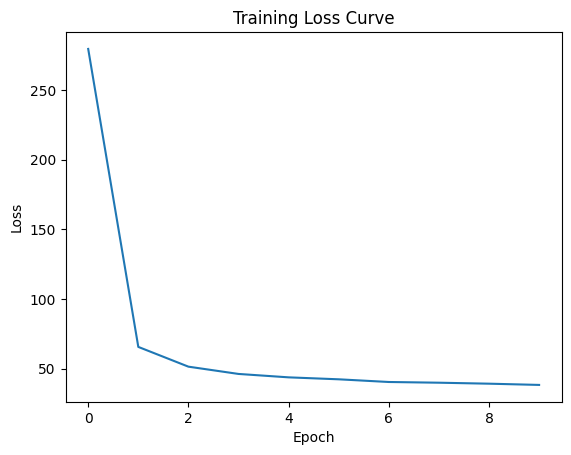

(LSTM(
   (inlayernorm): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
   (clayernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
   (lstm): LSTM(15, 256, bias=False, batch_first=True, bidirectional=True)
   (fc1): Linear(in_features=512, out_features=512, bias=True)
   (fc2): Linear(in_features=512, out_features=512, bias=True)
   (linear_class): Linear(in_features=512, out_features=6, bias=True)
 ),
 [279.4885425083339,
  65.67314185388386,
  51.4968044818379,
  46.27308345772326,
  43.82820654427633,
  42.42349716182798,
  40.49429933982901,
  39.98407355416566,
  39.281554128043354,
  38.394198595080525],
 [96.0638310304664,
  98.92178497832175,
  99.16164801389901,
  99.24695861851357,
  99.29058778617033,
  99.31220759692881,
  99.34736413604509,
  99.34760760238247,
  99.36094955767035,
  99.37565492444753])

In [23]:
model = LSTM.LSTM(input_dim=15, num_classes=6, hidden_dims=256, num_layers=1, dropout=0, bidirectional=True, use_layernorm=True)
train(model, train_dataset, batch_size, epochs, lr, weight_decay, device)


In [24]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print("Model saved successfully.")

In [25]:
save_model(model, "LSTM_model_10ep.pt")

Model saved successfully.


In [ ]:
import torch

# Class distribution
class_distribution = [28442, 469917, 236000, 32851,20606]

# Calculate inverse class frequencies
inv_class_frequencies = 1 / torch.tensor(class_distribution, dtype=torch.float)

# Normalize the weights to sum up to 1
class_weights = inv_class_frequencies / torch.sum(inv_class_frequencies)

print(class_weights)


In [ ]:
469917*0.0177

In [ ]:
# def ensemble_learning(model_class, train_dataset, test_loader, num_models, batch_size, epochs, lr, weight_decay, device):
#     models = []
#     ensemble_predictions = []

#     # Step 1: Create Multiple Model Instances
#     for _ in range(num_models):
#         model = model_class(input_dim=13, hidden_dims=128, num_classes=2, num_layers=6)
#         models.append(model)

#     # Step 2: Train Each Model
#     for model in models:
#         trained_model, _, _ = train(model, train_dataset, batch_size, epochs, lr, weight_decay, device)

#         # Step 3: Predict with Ensemble
#         model_predictions = []
#         with torch.no_grad():
#             for inputs, _ in test_loader:
#                 inputs = inputs.to(device)
#                 model.to(device)
#                 model.eval()
#                 outputs = model(inputs)
#                 _, predicted = torch.max(outputs, 1)
#                 model_predictions.append(predicted.cpu().numpy())
#         ensemble_predictions.append(model_predictions)

#     # Step 3 (Continued): Combine Predictions with Voting
#     ensemble_predictions = np.stack(ensemble_predictions, axis=0)  # Shape: (num_models, num_samples, 1)
#     ensemble_predictions = np.squeeze(ensemble_predictions, axis=2)  # Shape: (num_models, num_samples)
#     majority_voted_predictions = np.argmax(np.bincount(ensemble_predictions, axis=0), axis=0)

#     return majority_voted_predictions


In [ ]:
import os

In [ ]:
os.cpu_count()

In [ ]:
5//2